In [2]:
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.auth.transport.requests import Request
import os
import pickle

# Scope defines the level of access you need
SCOPES = ['https://www.googleapis.com/auth/drive']

creds = None
# The file token.pickle stores the user's access and refresh tokens, and is
# created automatically when the authorization flow completes for the first
# time.
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
# If there are no (valid) credentials available, let the user log in.
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = build('drive', 'v3', credentials=creds)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1048289826887-9kdehkbecc9otgj98jg0jjvo8nrgvbm3.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A50323%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=FlddEN5MeqJG7hnpvN0vT8R6jvOVgH&access_type=offline


In [3]:
def list_files_in_folder(folder_id):
    query = f"'{folder_id}' in parents"
    results = service.files().list(q=query, fields="files(id, name)").execute()
    items = results.get('files', [])
    if not items:
        print('No files found.')
    else:
        print('Files:')
        for item in items:
            print(u'{0} ({1})'.format(item['name'], item['id']))

# Replace YOUR_FOLDER_ID with your actual folder ID
list_files_in_folder('1Ap_ZH6vhoRpRxzu1eTdrpithBZKmBGE9')

Files:
DataSets (1R5KKeNFyJGT1qUn-r-gSHAhrCS1m_t66)


In [4]:
def find_file_id_by_path(service, path, parent_id='root'):
    """
    Find a file ID by its path.
    """
    parts = path.strip('/').split('/')
    file_id = parent_id
    for part in parts:
        # Search for the file by name and parent ID
        query = f"'{file_id}' in parents and name = '{part}' and trashed = false"
        response = service.files().list(q=query, spaces='drive', fields='files(id, name)').execute()
        files = response.get('files', [])
        if not files:
            print(f"No file found for part '{part}'.")
            return None
        file_id = files[0]['id']
    return file_id


In [5]:
def download_file_by_id(service, file_id):
    """
    Download a file's content by its file ID.
    """
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    fh.seek(0)
    return fh.read()


In [6]:
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import io
from googleapiclient.http import MediaIoBaseDownload
import pickle

def download_file(service, file_id):
    """
    Download a file from Google Drive specified by file_id.
    """
    request = service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while not done:
        _, done = downloader.next_chunk()

    fh.seek(0)
    return fh.getvalue()


In [7]:
import pandas as pd

def download_file_as_dataframe(service, file_id):
    file_content = download_file(service, file_id)
    return pd.read_csv(io.BytesIO(file_content))


In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import tensorflow.keras as keras


def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    return x, y

def plot_history(history: tf.keras.callbacks.History, ii: str):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model '+str(ii)+' accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model '+str(ii)+' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    print('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    #y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = model.predict(x_test, batch_size=512, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    print("\n{}".format(classification_report(y_test, y_pred)))

In [11]:
def upload_model_to_drive(service, file_name, folder_id, mime_type='application/octet-stream'):
    file_metadata = {'name': os.path.basename(file_name), 'parents': [folder_id]}
    media = MediaFileUpload(file_name, mimetype=mime_type)
    file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    print('Uploaded File ID: %s' % file.get('id'))

In [12]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score



            
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")


result="C:/Users/benzaied saif/Desktop/model/ML_algos/results_for_ml_algo.csv" #a CSV file is named in which the results are saved.
# Replace 'YOUR_FILE_ID' with the actual file ID
file_id = '1ZLpmbcBSIfyKlZGHO2tuVk3xGK8J_cBy'
df = download_file_as_dataframe(service, file_id)
print(df.head())

path=""
repetition=10


def folder(f_name): #this function creates a folder named "results" and "result_graph_1" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

folder_name="C:/Users/benzaied saif/Desktop/model/ML_algos/"
folder(folder_name)
folder_name="C:/Users/benzaied saif/Desktop/model/ML_algos/result_graph_ML_algos/"
folder(folder_name)


#The machine learning algorithms to be used are defined in a dictionary (ml_list).
ml_list={
"Naive Bayes":GaussianNB(),
"QDA":QDA(),
"Random Forest":RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
"ID3" :DecisionTreeClassifier(max_depth=5,criterion="entropy"),
"AdaBoost":AdaBoostClassifier(),
"MLP":MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500),
"Nearest Neighbors":KNeighborsClassifier(3)}


seconds=time.time()#time stamp for all processing time






with open(result, "w", newline="",encoding="utf-8") as f:#a CSV file is created to save the results obtained.
    wrt = csv.writer(f)
    wrt.writerow(["ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"])




   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              80.0      5237610.0                4.0                     4.0   
1              53.0       333394.0                1.0                     1.0   
2             443.0       103990.0               10.0                     5.0   
3              53.0        23559.0                1.0                     1.0   
4              80.0     97934363.0               18.0                    16.0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                       1178.0                        354.0   
1                         46.0                         62.0   
2                        966.0                       1631.0   
3                         43.0                         59.0   
4                        868.0                       3925.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                 1178.0                    0.0            

In [13]:
X, Y = preprocessing(df)
del df

ML algorithm       accuracy        Precision       Recall          F1-score        Time           
Naive Bayes        0.71            0.44            0.78            0.47            11.4892        


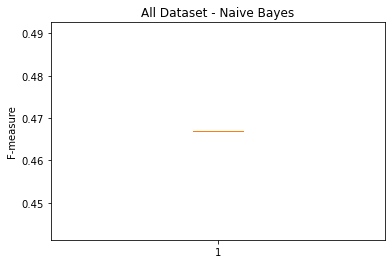

QDA                0.96            0.59            0.72            0.61            128.7366       


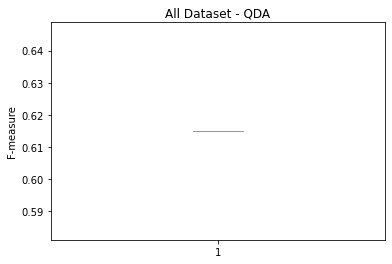

Random Forest      0.91            0.25            0.17            0.19            11.1978        


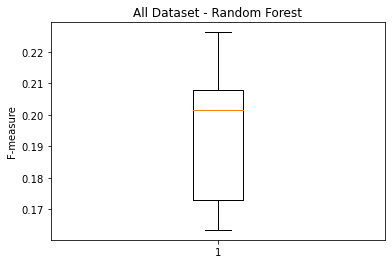

ID3                0.97            0.57            0.48            0.51            25.3901        


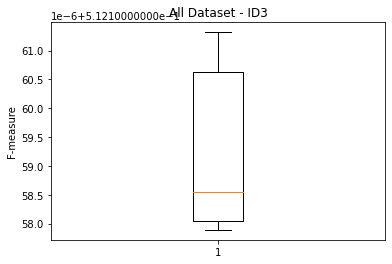

AdaBoost           0.87            0.1             0.11            0.11            293.5021       


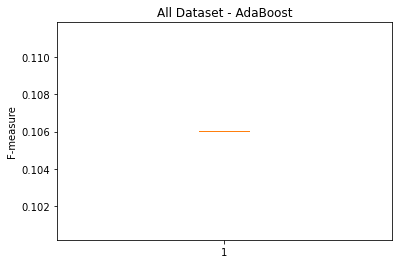

MLP                0.99            0.73            0.64            0.65            936.2211       


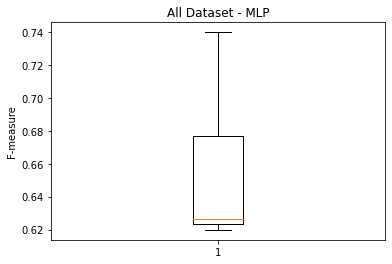

Nearest Neighbors  0.99            0.79            0.78            0.79            11383.7676     


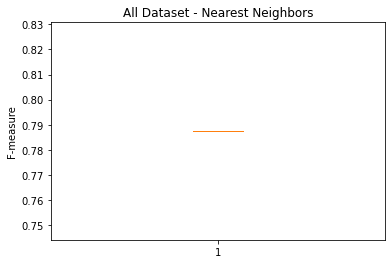

*** TRAINING FINISH ***
Total operation time: =  128669.90987038612 seconds


In [18]:
print ('%-17s  %-15s %-15s %-15s %-15s %-15s' % ("ML algorithm","accuracy","Precision", "Recall" , "F1-score","Time"))# print output header 

for ii in ml_list: #this loop runs on the list containing the machine learning algorithm names. Operations are repeated for all the 7 algorithm
        precision=[]
        recall=[]
        f1=[]
        accuracy=[]
        t_time=[]
        for i in range(repetition): # This loop allows cross-validation and machine learning algorithm to be repeated 10 times
            second=time.time()#time stamp for processing time

            # cross-validation
            X_train, X_test, y_train, y_test = train_test_split(X, Y,#  data (X) and labels (y) are divided into 2 parts to be sent to the machine learning algorithm (80% train,%20 test). 
                test_size = 0.20, random_state = repetition)#  So, in total there are 4 tracks: training data(X_train), training tag (y_train), test data(X_test) and test tag(y_test).


            #machine learning algorithm is applied in this section
            model = ml_list[ii]#choose algorithm from ml_list dictionary                                                                          
            model.fit(X_train, y_train)
            predict =model.predict(X_test)
            
            """# Save the full model
            model.save(os.path.join(r"C:/Users/benzaied saif/Desktop/model/ML_algos/", str(ii)+"_full_model.h5"))
            
            upload_model_to_drive(service, os.path.join(r"C:/Users/benzaied saif/Desktop/model/ML_algos/", str(ii)+"_full_model.h5"), '1mIKKTtCuPqWAjmoBAHeCfdnZBAp1QiKj')
            """
        
            #makes "classification report" and assigns the precision, f-measure, and recall values.s.    
            

            f_1=f1_score(y_test, predict, average='macro')
            pr=precision_score(y_test, predict, average='macro')
            rc=recall_score(y_test, predict, average='macro')
            
            
            precision.append(float(pr))
            recall.append(float(rc))
            f1.append(float(f_1))
            accuracy.append(model.score(X_test, y_test))
            t_time.append(float((time.time()-second)) )



            
        print ('%-17s  %-15s %-15s %-15s %-15s %-15s' % (ii,str(round(np.mean(accuracy),2)),str(round(np.mean(precision),2)), 
            str(round(np.mean(recall),2)),str(round(np.mean(f1),2)),str(round(np.mean(t_time),4))))#the result of the ten repetitions is printed on the screen.

        with open(result, "a", newline="",encoding="utf-8") as f: # all the values found are saved in the opened file.
            wrt = csv.writer(f)
            for i in range(0,len(t_time)):
                wrt.writerow([ii,accuracy[i],precision[i],recall[i],f1[i],t_time[i]])#file name, algorithm name, precision, recall and f-measure are writed in CSV file
   
     # In this section, Box graphics are created for the results of machine learning algorithms and saved in the feaure_graph folder.
        plt.boxplot(f1)
        plt.title("All Dataset - " +str(ii))
        plt.ylabel('F-measure')
        plt.savefig(folder_name+str(ii)+".pdf",bbox_inches='tight', papertype = 'a4', orientation = 'portrait', format = 'pdf')
        plt.show()# you can remove the # sign if you want to see the graphics simultaneously

print("*** TRAINING FINISH ***")
print("Total operation time: = ",time.time()- seconds ,"seconds")
del X, Y